# Variances

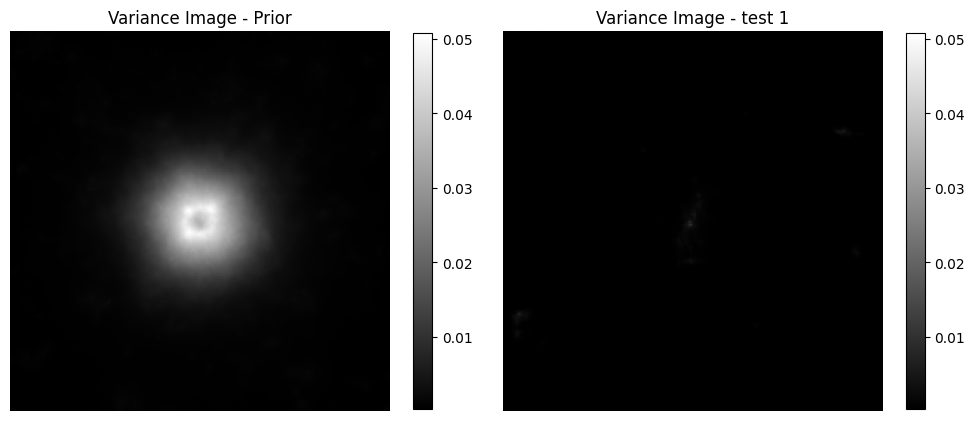

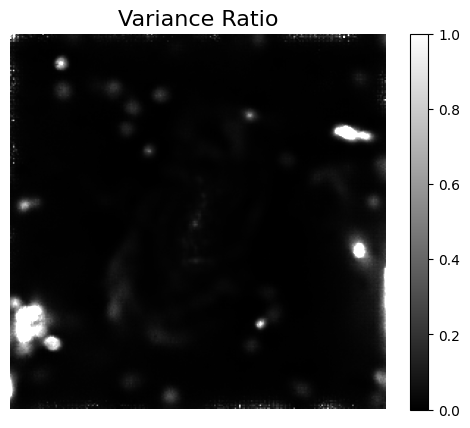

Average posterior variance in central circular region:  0.0006688136
Average posterior variance/prior variance ratio in central circular region:  0.019448187


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

def load_images_from_npz(file_path):
    data = np.load(file_path)
    images = data['arr_0']  # Assuming the default key in the .npz file is 'arr_0'
    return images

def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            try:
                img = Image.open(img_path)
                img_array = np.array(img).astype(np.float32) / 255.0
                images.append(img_array)
            except Exception as e:
                print(f"Could not load image {filename}: {e}")
    return np.array(images)

def compute_variance(images):
    # Compute pixel-wise variance across images
    variance = np.var(images, axis=0)
    # Take the mean across the three channels (axis=-1 represents the color channels)
    variance_mean = np.mean(variance, axis=-1)
    return variance_mean

def compute_mean(images):
    # Compute pixel-wise and channel-wise mean
    mean = np.mean(images, axis=0)
    return mean

def plot_variance(variance1, variance2, title1, title2):
    # Plot the average variance image across channels
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    vmin = variance1.min()
    vmax = variance1.max()

    im1 = axes[0].imshow(variance1, cmap='gray', vmin=vmin, vmax=vmax)
    axes[0].set_title(title1)
    axes[0].axis('off')
    fig.colorbar(im1, ax=axes[0], shrink=0.8)

    im2 = axes[1].imshow(variance2, cmap='gray', vmin=vmin, vmax=vmax)
    axes[1].set_title(title2)
    axes[1].axis('off')
    fig.colorbar(im2, ax=axes[1], shrink=0.8)
    
    plt.tight_layout()
    plt.show()

def plot_variance_ratio(variance1, variance2):
    # Calculate and plot the variance ratio
    ratio = variance1 / (variance2 + 1e-10)  # Add a small value to prevent division by zero

    plt.figure(figsize=(5, 5))  # Adjust figure size if needed
    plt.imshow(ratio, cmap='gray', vmin=0, vmax=1)
    plt.title('Variance Ratio', fontsize=16)
    plt.axis('off')
    cbar = plt.colorbar(shrink=0.8)  # Adjust color bar size
    plt.tight_layout()
    plt.show()

def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

    mask = dist_from_center <= radius
    return mask

def compute_mean_in_circular_region(image):
    # Assume all images have the same dimensions
    h, w = image.shape
    mask = create_circular_mask(h, w, radius=30)

    masked_means = []
    masked_img = image[mask]  # Apply the mask

    return np.mean(masked_img)  # Return the average

# Load images from the .npz files
file_path1 = os.getcwd() + '/samples/samples_1024x256x256x3_525k.npz'  # Update this with the actual file path
file_path2 = os.getcwd() + '/samples/samples_256x256x256x3_inv_mag_real_HSC_test1.npz'  # Update this with the actual file path

train_imgs_path = os.getcwd() + '/Ideal_train/TNG_train_idealized'

#images_train = load_images_from_folder(train_imgs_path)#[:, 123:133, 123:133, :]

images1 = load_images_from_npz(file_path1)
images2 = load_images_from_npz(file_path2)

# Compute variance images
variance1 = compute_variance(images1)
variance2 = compute_variance(images2)

# Plot the variance images
plot_variance(variance1, variance2, 'Variance Image - Prior', 'Variance Image - test 1')

# Plot the variance ratio images
plot_variance_ratio(variance2, variance1)

# Compute the mean in the central circular region
mean_in_circular_region1 = compute_mean_in_circular_region(variance1)
mean_in_circular_region2 = compute_mean_in_circular_region(variance2)

mean_ratio_in_circular_region = compute_mean_in_circular_region(variance2 / (variance1 + 1e-10))


print("Average posterior variance in central circular region: ", mean_in_circular_region2)

print("Average posterior variance/prior variance ratio in central circular region: ", mean_ratio_in_circular_region)

# Averaged samples

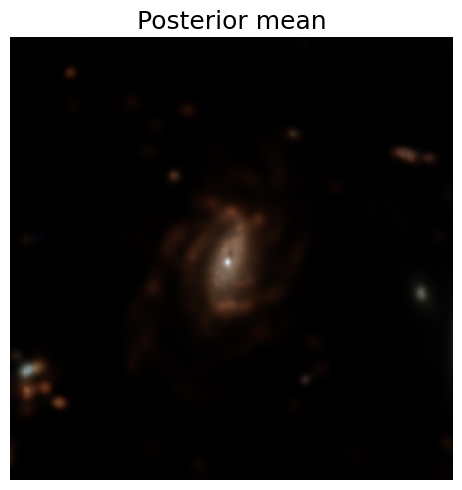

In [4]:
avg = compute_mean(images2)
plt.figure(figsize=(5, 5))  # Adjust figure size if needed
plt.imshow(avg.clip(0,1))
plt.title('Posterior mean', fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()